# Project1: Transport Access Analysis

@Author: Jeffery Brown (daddyjab)<br>
@Date: 1/9/19

-------

# <span style="color:darkblue">Analysis of Various Yelp Metrics vs.<br>Total Number of CTA Stops on a per-Zipcode Basis</span>

## <span style="color:darkblue">Summary:</span>
* x
* y
* z

## <span style="color:darkblue">Data Gathered and Plotted</span>
* Plots are based upon a data set that was merged by zipcode using data from:
  * Yelp metrics for restaurants in Chicago provided by a team member
  * Chicago CTA transit stop data
  * US Zipcode to mapping to latitude/longitude coordinates
  
* Both scatter plots and bar (column) plots were generated for 3 Yelp metrics:
  * Average Yelp Ratings per Zipcode vs. # of CTA Stops per Zipcode
  * Average Yelp Price (# of $) per Zipcode vs. # of CTA Stops per Zipcode
  * Median # of Yelp Reviews per Zipcode vs. # of CTA Stops per Zipcode
  
* For each plot, marker color was varied based upon the value of the Yelp metric being plotted.
* For the scatter plots, a moving average trend line (window size = 5 samples) was added to help highlight any trend in the data
* For the bar plots, each bar represents the median of the Yelp characteristic for each bar.  Error bars based upon the standard error of the mean are included to highlight variation in the underlying data for each bar.

## <span style="color:darkblue">Results</span>
### <span style="color:blue">Average Yelp Ratings per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar.png" /> |

* Moving average trend of the Average Yelp Ratings per Zipcode seems relatively flat or a fairly mild decline until about 300 CTA stops per zipcode, which shows a peak.
* <span style="color:maroon">Questions to consider:
    * What zipcodes are associated with the peak value at around 300 CTA stops per zipcode?
    * What demographic or other factors might shed light on this peak?
</span>
<br>

### <span style="color:blue">Average Yelp Price (# of $) per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Avg_Yelp_Price_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar.png" /> |

* Moving average trend of the Average Yelp Price (# of $) per Zipcode seems to show a mild decline starting with about 100 CTA stops per zipcode
* A linear regression across at least a range of # of CTA Stop values may be relevant.
<br>

### <span style="color:blue">Median # of Yelp Reviews per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar.png" /> |

* Most interesting plot so far.
* Moving average trend of the Median # of Yelp Reviews per Zipcode shows a clear decline across the entire range of # of CTA Stops per Zipcode values
* The distribution of individual sample points in the scatter plot and the error bars in the bar plot both seem to support that the decline is significant - _very exciting!_
* Expecting that a linear regression across will show a usable trend.
* <span style="color:maroon">Questions to consider:
    * What does it mean that restaurants in zipcodes with fewer CTA stops tend to have a higher number of Yelp reviews?
    * And, what does it mean it the context of the other relationships plotted above?
</span>
<br>

## <span style="color:maroon">Next Steps:</span>
  * Linear regression analysis to determine trend line characteristics for:
      * Average Yelp Price (# of $) per Zipcode vs. # of CTA Stops per Zipcode
      * Median # of Yelp Reviews per Zipcode vs. # of CTA Stops per Zipcode
  
  * Create a Google Maps plot of the 3 Yelp metrics noted above:
      * Marker layer of all of the Zipcode lat/long coordinates, with the marker size determined by a Yelp metric.
      * Marker labels providing the key Yelp metric.
      * Marker info boxes providing additional Yelp metric and the associated # of Chicago CTA Stops for each zipcode.
      * A heat map layer of the # of Chicago CTA Stops
      


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import time

import random as random
import gmaps
from pprint import pprint

#import pycountry
#from IPython.display import (Image, HTML)
#import logging
import math
from scipy import stats

# Functions to find the distance between 2 lat/long coordinates
# Description: https://pypi.org/project/geopy/1.9.1/
from geopy.distance import (distance, great_circle)

# Keys
from api_config import (key_openweathermap, key_gmaps)

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy


## Useful distance related functions, for later... maybe...

In [2]:
# Function to find the a (lat, long) coord that is closest to a reference point
#  and then return the index of the coord in the provided list of coords
# Note: If the coordinates are duplicated in the list of coordinates,
#        then the index of the first coordinate is returned
# r: reference point as a tuple (lat, long)
# stop_coords: a list of tuples with ('stop_lat', 'stop_lon')
#               generated from the dataframe containing CTA stops

def closest_coord(coords, r):
    # Find the lat/long tuple closest to the reference point provided
    close_point = min( coords, key=lambda z: distance( z, r ).feet )
    
    # Get the index of this closest point in the list of coordinates
    # (Note, if there are dups in the list just return the first index)
    retval = coords.index( close_point )
    return retval

## Other useful functions

In [4]:
# USE LATER:
# Generate the list of CTA stop coordinates,
# which can be used to lookup the CTA stop  that is closest to a specific restaurant
# stop_coords = list( zip( c_cta_stops_df['stop_lat'], c_cta_stops_df['stop_lon'] ) )

# Use the index of the closest CTA stop to extract specific info out of the CTA stop dataframe
# closest_stop_index = closest_coord( stop_coords, refpt)
# c_cta_stops_df['stop_name'][closest_stop_index]

# Sample of using the distance function - in case needed later...
# a1 = (39.7612992, -86.1519681)
# a2 = (39.762241,  -86.158436 )
# dist_d = distance(a1, a2).feet
# print (dist_d)

In [107]:
# Function to generate a linear regression and a set of data points for the trend line
def gen_linear_trend( a_x, a_y , a_start=None, a_stop=None ):    
    # Perform the linear regression
    lr = stats.linregress(a_x[a_start:a_stop], a_y[a_start:a_stop] )

    pprint(lr)
    
    # Generate a set of data points for the trend line
    # trend_line = lr.slope * a_x + lr.intercept
    trend_line = [ x * lr.slope + lr.intercept for x in a_x[a_start:a_stop] ]

    # Create a label describing the trend
    trend_label = f"Trend: Y-value = {lr.slope:.2f} x [ X-value ] + {lr.intercept:.2f}"
    trend_label += f"\nCorrelation (R-Value): {lr.rvalue:.2f}"
    trend_label += f"\nProbablity of Linear Relationship (p-Value): {(1-lr.pvalue):.2%}"
    
    return { 'trend_line': trend_line, 'trend_label': trend_label }

In [96]:
[ x * lr.slope + lr.intercept for x in list(merged_rest_df['Total CTA Stops']) ]

NameError: name 'lr' is not defined

In [103]:
#tl = gen_linear_trend( range(0,len(merged_rest_df['Total CTA Stops'])), merged_rest_df['Median Reviews'])

tl = gen_linear_trend( list(merged_rest_df['Total CTA Stops']), list(merged_rest_df['Median Reviews']) ) 


LinregressResult(slope=-0.957501007840161, intercept=354.902996184715, rvalue=-0.5212604732554643, pvalue=4.493717288992012e-05, stderr=0.21532672974495023)


In [108]:
tl = gen_linear_trend( range(0,len(c_cta_stop_bin_df['Median Reviews'])), c_cta_stop_bin_df['Median Reviews'], 0, 11)
pprint(tl)

LinregressResult(slope=-40.554545454545455, intercept=408.6590909090909, rvalue=-0.8615006743675482, pvalue=0.0006538912172912905, stderr=7.967426943678031)
{'trend_label': 'Trend: Y-value = -40.55 x [ X-value ] + 408.66\n'
                'Correlation (R-Value): -0.86\n'
                'Probablity of Linear Relationship (p-Value): 99.93%',
 'trend_line': [408.6590909090909,
                368.1045454545454,
                327.54999999999995,
                286.99545454545455,
                246.44090909090906,
                205.8863636363636,
                165.33181818181816,
                124.7772727272727,
                84.22272727272724,
                43.66818181818178,
                3.113636363636317]}


In [109]:
len(tl['trend_line'])

11

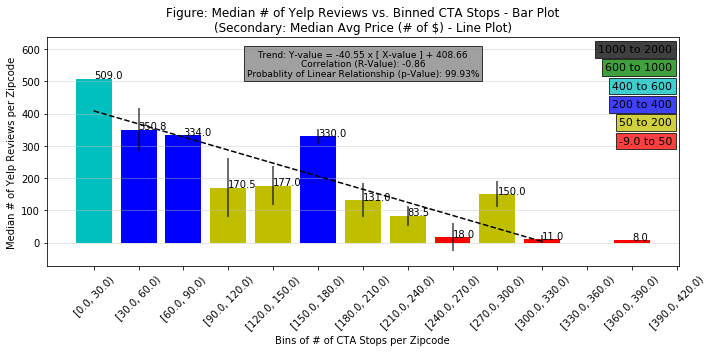

In [110]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Price (# of $) - Line Plot)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_and_Secondary_Avg_Price_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'data_trend': tl['trend_line'],
    'data_trend_label': tl['trend_label'],
    'data_trend_label_loc_h': 0.5,
    'data_trend_label_loc_v': 0.95,
    
#    'y2_label':'Median Avg Price (# of $) per Zipcode',
#    'y2_column':'Avg Price (# of $)',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

In [3]:

# Function to generate an array containing the
#  moving average of the list provided in the argument
def moving_average(values, window_size):
    # Create a "window" based upon the window size with value 1/window_size
    window = np.ones(int(window_size))/float(window_size)
    
    # Calculate the average of the window moving across the elements of "values"
    #  using the convolve function to multiply and add
    return np.convolve( values, window, 'same')

In [ ]:
# TODO: Refactor the scatter plot function to extract the moving average trend line code
# into a separate standaline function.  Then the moving average trend can be passed into
# the scatter plot function just like the linear trend line is with the bar plot.
# But... don't need this extracted yet -- can wait...
# Function to generate a linear regression and a set of data points for the trend line
def gen_moving_average_trend( a_x, a_y , a_win_size=5, a_start=None, a_stop=None ):

    # Generate a trend line using the moving average
    # First, generate a dataframe that is sorted by c_x_column
    a_data_sorted_df = a_data_df.sort_values(by=c_x_column).reset_index(drop=True)

    # Set the window size for the moving average
    trend_window_size = a_ma_window_size

    # Calculate the moving average
    trend = moving_average(a_data_sorted_df[c_plotcolumn], trend_window_size)


    
    # Perform the linear regression
    lr = stats.linregress(x_axis[a_start:a_stop], y_axis[a_start:a_stop] )

    # Generate a set of data points for the trend line
    trend_line = lr.slope * x_axis + lr.intercept

    # Create a label describing the trend
    trend_label = f"Trend: y = {lr.slope:.2f} x [CTA Stop Bin] + {lr.intercept:.2f}"
    trend_label += f"\nCorrelation (R-Value): {lr.rvalue:.2f}"
    trend_label += f"\nProbablity of Linear Relationship (p-Value): {(1-lr.pvalue):.2%}"
    
    return { 'trend_line': trend_line, 'trend_label': trend_label }

In [11]:
# Function to make a scatter plot of selected columns
# Arguments: a dictionary 'a_plot_dict' with elements
#    'data_df': dataframe with data to plot
#    'y_column': Column to be plotted on y-axis of scatter plot
#    'x_column': Column to be plotted on x-axis of scatter plot
#    'color_list': list of Colors to use for markers (same size as a_color_thresh)
#    'color_thresh': list of y-value thresholds used to select a color
#    'ma_window_size': Window size used for moving average
#    'chart_title': Title of the chart
#    'y_label': Label for the y-axis
#    'x_label': Label for the y-axis
#    'save_file': Save file for the plot

def gen_scatter_plot(a_plot_dict):
    
    # Extract the arguments from the a_plot_dict arg
    a_chart_title = a_plot_dict['chart_title']
    a_save_file = a_plot_dict['save_file']

    a_data_df = a_plot_dict['data_df']
    a_y_label = a_plot_dict['y_label']
    a_y_column = a_plot_dict['y_column']
    a_color_list = a_plot_dict['color_list']
    a_color_thresh = a_plot_dict['color_thresh']

    a_x_label = a_plot_dict['x_label']
    a_x_column = a_plot_dict['x_column']

    a_ma_window_size = a_plot_dict['ma_window_size']

#>>>>>
    # Optional: Y-axis trend line (primary axis)
    if 'data_trend' in a_plot_dict.keys():
        a_trend_plotflag = True
        a_data_trend = a_plot_dict['data_trend']

        # If a trend_label has been specified then display it
        # Otherwise, no trend label will be displayed
        try:
            a_data_trend_label = a_plot_dict['data_trend_label']
        except KeyError:
            a_data_trend_label = None
            
        # If a trend_label location is specified, use it
        # Otherwise, use defaults
        try:
            a_data_trend_label_loc_h = a_plot_dict['data_trend_label_loc_h']
            a_data_trend_label_loc_v = a_plot_dict['data_trend_label_loc_v']
        except KeyError:
            a_data_trend_label_loc_h = 0.03
            a_data_trend_label_loc_v = 0.05

    else:
        a_trend_plotflag = False
    
    # TODO: Implement this plot on secondary axis - later...
    # Optional: Secondary Y-axis plot
    if 'y2_column' in a_plot_dict.keys():
        a_y2_plotflag = True
        a_y2_label = a_plot_dict['y2_label']
        a_y2_column = a_plot_dict['y2_column']
    else:
        a_y2_plotflag = False        
#>>>>>


    # Generate Scatter Plots for key metrics vs. 'Total CTA Stops'
    # Add trend lines to each and look for patterns
    # Generate a scatter plot
    fig, ax = plt.subplots(figsize=(10,5))

    # Color scheme for markers
    color_list = a_color_list

    # Thresholds for selecting colors
    color_threshold_list = a_color_thresh

    # Initialize array of marker colors
    marker_colors = []

    # The value to plot on the y-axis
    c_plotcolumn = a_y_column

    # The value to plot on the x-axis
    c_x_column = a_x_column

    # Create the markers by iterating through zipcode
    for ci in a_data_df.index:
        # Set the color of the markers based upon temperature
        c_plotvalue = a_data_df.loc[ci,c_plotcolumn]

        # If the value is not populated for this bin,
        #  continue to move to the next value
        if math.isnan(c_plotvalue):
            continue

        # Select marker color and add it to the list
        marker_colors.append( color_list[ np.digitize(c_plotvalue, color_threshold_list) ] )

    # Plot a scatter plot
    plt.scatter(a_data_df[c_x_column], a_data_df[c_plotcolumn], c=marker_colors, alpha=0.5)

#>>>>
    # Generate a trend line using the moving average
    # First, generate a dataframe that is sorted by c_x_column
    a_data_sorted_df = a_data_df.sort_values(by=c_x_column).reset_index(drop=True)

    # Set the window size for the moving average
    trend_window_size = a_ma_window_size

    # Calculate the moving average
    trend = moving_average(a_data_sorted_df[c_plotcolumn], trend_window_size)

    # Generate the trend plot
    plt.plot(a_data_sorted_df[c_x_column], trend, color='k', linestyle='--')

#>>>>
    # Add a value for this point if it is the maximum and minimum points
    # Get the index values for value is max and min
    # Note: Could end up being multiple data points,
    #  so select the first max, and the last min
    ci_max = a_data_df.loc[ a_data_df[c_plotcolumn] == a_data_df[c_plotcolumn].max() ].index
    ci_min = a_data_df.loc[ a_data_df[c_plotcolumn] == a_data_df[c_plotcolumn].min() ].index

    # Place the values for these points on the scatter plot
    text_offset = 0
    plt.text(float(a_data_df.loc[ci_max[0],c_x_column]),
             float(a_data_df.loc[ci_max[0], c_plotcolumn ]) + text_offset,
             f"{float(a_data_df.loc[ci_max[0], c_plotcolumn ]):.1f}" , ha='center')

    plt.text(float(a_data_df.loc[ci_min[-1],c_x_column]),
             float(a_data_df.loc[ci_min[-1], c_plotcolumn ]) - text_offset,
             f"{float(a_data_df.loc[ci_min[-1], c_plotcolumn ]):.1f}" , ha='center')

    # Set the x tick marks and labels
    # plt.xticks(merged_rest_df.loc[ci_max,c_x_column], merged_rest_df.loc[ci_max,c_x_column], rotation=45)
    # TODO: Change the x_tick labels to match this c_x_column data
    #x_gran = 10.0
    #plt.xticks(np.arange(-90.0,90.0+x_gran,x_gran),
    #           [str(x) for x in np.arange(-90.0,90.0+x_gran,x_gran)],
    #           rotation=90)

    # Set the y access limits to add room for the value labels
    y_bot = a_data_df[c_plotcolumn].min()
    y_top = a_data_df[c_plotcolumn].max()
    y_range = y_top-y_bot

    y_bot -= y_range * 0.15
    y_top += y_range * 0.15
    plt.ylim( bottom=y_bot, top=y_top)

    # Adjust the tick marks to be more granular
    # plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=y_range/10))

    plt.xlabel(a_x_label)
    plt.ylabel(a_y_label)
    plt.title(a_chart_title)

    plt.grid(True, axis='both', color='0.75', alpha=0.5)

    # Add a key for the color coding used on the plot
    for i in range(1,len(color_threshold_list)):
        # Text to display
        box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
        box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}

        # Plot this
        plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
                 box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

    # Add a key for the moving average
    box_text = f"Trend: Moving Average\n(Window Size={trend_window_size})"
    box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
    plt.text(0.03, 0.05,
             box_text, transform=ax.transAxes,
             fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=box_fmt)

    # Add a horizontal line at the y = 0% level
    # plt.hlines(y=0, xmin=-90, xmax=+90, alpha=0.5)

    plt.tight_layout()
    plt.show()
    
    # Save the plot
    fig.savefig(a_save_file)

In [23]:
# Function to make a bar plot of selected columns
# Arguments: a dictionary 'a_plot_dict' with elements
#    'chart_title': Title of the chart
#    'save_file': Save file for the plot

#    'data_df': dataframe with binned data to plot on primary axis
#    'data_sem_df': dataframe standard errors of mean for the binned data to plot in data_df
#    'y_label': Label for the y-axis
#    'y_column': Column to be plotted on y-axis of plot
#    'color_list': list of Colors to use for markers (same size as a_color_thresh)
#    'color_thresh': list of y-value thresholds used to select a color

#    'data_trend': List (or Series) with trend line to plot on primary axis

#    'y2_label': Label for the secondary y-axis
#    'y2_column': Column to be plotted on secondary y-axis

#    'x_label': Label for the x-axis
#    'x_column': Column to be plotted on x-axis of scatter plot

def gen_bar_plot(a_plot_dict):
    
    # Extract the arguments from the a_plot_dict arg
    # Chart level parameters
    a_chart_title = a_plot_dict['chart_title']
    a_save_file = a_plot_dict['save_file']

    # X-axis parameters
    a_x_label = a_plot_dict['x_label']
    a_x_column = a_plot_dict['x_column']
 
    # Y-axis parameters (primary axis)
    a_data_df = a_plot_dict['data_df']
    a_data_sem_df = a_plot_dict['data_sem_df']
    a_y_label = a_plot_dict['y_label']
    a_y_column = a_plot_dict['y_column']
    a_color_list = a_plot_dict['color_list']
    a_color_thresh = a_plot_dict['color_thresh']
    
    # Optional: Y-axis trend line (primary axis)
    if 'data_trend' in a_plot_dict.keys():
        a_trend_plotflag = True
        a_data_trend = a_plot_dict['data_trend']

        # If a trend_label has been specified then display it
        # Otherwise, no trend label will be displayed
        try:
            a_data_trend_label = a_plot_dict['data_trend_label']
        except KeyError:
            a_data_trend_label = None
            
        # If a trend_label location is specified, use it
        # Otherwise, use defaults
        try:
            a_data_trend_label_loc_h = a_plot_dict['data_trend_label_loc_h']
            a_data_trend_label_loc_v = a_plot_dict['data_trend_label_loc_v']
        except KeyError:
            a_data_trend_label_loc_h = 0.03
            a_data_trend_label_loc_v = 0.05

    else:
        a_trend_plotflag = False
    
    # Optional: Secondary Y-axis plot
    if 'y2_column' in a_plot_dict.keys():
        a_y2_plotflag = True
        a_y2_label = a_plot_dict['y2_label']
        a_y2_column = a_plot_dict['y2_column']
    else:
        a_y2_plotflag = False        

    # Generate the plot
    fig, ax = plt.subplots(figsize=(10,5))

    # Color scheme for markers
    color_list = a_color_list

    # Thresholds for selecting colors
    color_threshold_list = a_color_thresh

    # Generate bars by iterating through each bin
    for ci in a_data_df.index:

        # Set color bars based upon temperature
        c_plotvalue = a_data_df.loc[ci,a_y_column]

        # If temperature is not populated for this bin,
        #  continue to move to the next bin
        if math.isnan(c_plotvalue):
            continue

        # Set the error bars using the standard deviation of the mean (sem)
        c_sem = a_data_sem_df.loc[ci,a_y_column]

        # Select marker color and add it to the list
        c_color = color_list[ np.digitize(c_plotvalue, color_threshold_list) ]

        # Set the placement location for the value text
        text_offset = 0
        c_textloc = c_plotvalue + text_offset

        # Get the value associated with this bar
        c_valuetext = f"{c_plotvalue:.1f}"

        # Plot a bar
        plt.bar(ci, c_plotvalue, color=c_color, yerr=c_sem, error_kw={'alpha':0.75})

        # Place the value on this bar
        plt.text(ci, c_textloc, c_valuetext , ha='left')

    plt.xticks(range(len(a_data_df.index)), a_data_df[a_x_column], rotation=45)

    # Set the y access limits to add room for the value labels
    y_bot = a_data_df[a_y_column].min()
    y_top = a_data_df[a_y_column].max() + 0.5*a_data_sem_df[a_y_column].max()
    y_range = y_top-y_bot

    y_bot -= y_range * 0.15
    y_top += y_range * 0.15
    plt.ylim( bottom=y_bot, top=y_top)

    # Adjust the tick marks to be more granular
    #plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

    plt.xlabel(a_x_label)
    plt.ylabel(a_y_label)
    plt.title(a_chart_title)

    plt.grid(True, axis='y', color='0.75', alpha=0.5)
    # plt.legend(loc="best")

    # Add a key for the color coding used on the plot
    for i in range(1,len(color_threshold_list)):
        # Text to display
        box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
        box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}

        # Plot this
        plt.text(0.99, 0.97 -((len(color_threshold_list)-i-1)*0.08),
                 box_text, transform=ax.transAxes, fontsize=11,
                 verticalalignment='top', horizontalalignment='right', bbox=box_fmt)

    # Add a horizontal line at the y = 0% level
    # plt.hlines(y=0, xmin=-1, xmax=len(a_data_df.index), alpha='0.5')

    # Add a trend line on the primary axis if it has been specified
    if a_trend_plotflag:
        plt.plot(x_axis, a_data_trend,
                 color='k', linestyle='dashed')
        
        
        # Add a key for the trend line if it has been specified
        if a_data_trend_label != None:
            box_text = a_data_trend_label
            box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
            plt.text(a_data_trend_label_loc_h, a_data_trend_label_loc_v,
                     box_text, transform=ax.transAxes,
                     fontsize=9, verticalalignment='top', horizontalalignment='center', bbox=box_fmt)

    # Add plot on secondary axis if it has been specified
    if a_y2_plotflag:
        # Align the x-axis of the secondary plot with the primary plot
        ax2 = ax.twinx()
        
        # Create the line plot using same x-axis as primary plot
        ax2.plot(range(len(a_data_df.index)), a_data_df[a_y2_column],
                 color='brown', marker='o', linestyle='solid')
        
        # Set the label for the y2 secondary axis
        ax2.set_ylabel(a_y2_label, color="brown")
    
    plt.tight_layout()
    plt.show()
        
    # Save the plot
    fig.savefig(a_save_file)

In [ ]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. CTA Stops - Scatter Plot\n(with Linear Trend Line)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Scatter_and_Linear_Trend_Line.png'

    'data_df':merged_rest_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'data_trend': tl['trend_line'],
    'data_trend_label': tl['trend_label'],
    'data_trend_label_loc_h': 0.5,
    'data_trend_label_loc_v': 0.95,
    
    'x_label':'# of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops',

#    'ma_window_size':5,
}

gen_scatter_plot(plot_dict)


# Get the Merged Data for Analysis

In [7]:
# Read in the merged Restaurant and Chicago CTA stop + zipcode info previously cleaned/saved
i_file = "../Data/merged_restaurants_and_CTA_stops.csv"

# Read the data into a dataframe
merged_rest_df = pd.read_csv(i_file, index_col='zip')
merged_rest_df.head()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude
zip,,,,,,,,,
60601,14,3.500000,11535,397.5,823.928571,1.928571,52.0,41.885310,-87.622116
60602,11,3.863636,4086,390.0,371.454545,1.454545,39.0,41.883073,-87.629149
60603,25,3.680000,14205,509.0,568.200000,2.040000,11.0,41.880188,-87.625509
60604,2,4.000000,813,406.5,406.500000,1.500000,58.0,41.878095,-87.628461
60605,32,3.953125,14871,334.0,464.718750,1.875000,60.0,41.867566,-87.617228


In [8]:
merged_rest_df.describe()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,55.000000,55.000000,55.000000
mean,27.684211,3.797355,9800.315789,182.921053,253.762122,1.650841,176.618182,41.869512,-87.673519
std,23.903196,0.336161,13880.941653,163.087586,237.742327,0.301364,89.998866,0.091434,0.062758
min,1.000000,2.652174,11.000000,8.000000,9.842105,1.000000,11.000000,41.663809,-87.827132
25%,10.000000,3.612903,681.000000,49.000000,85.111111,1.451613,101.000000,41.805907,-87.712374
50%,20.000000,3.868421,3694.000000,131.000000,164.541667,1.692308,191.000000,41.882066,-87.662604
75%,32.000000,4.000000,13682.000000,306.000000,406.260870,1.869565,240.000000,41.943241,-87.628805
max,83.000000,4.500000,62914.000000,753.500000,1165.074074,2.425926,386.000000,42.010019,-87.552739


In [9]:
# Drop any rows that do not have CTA Stop data or Lat/Long coords
merged_rest_df.dropna(how='any', inplace=True)
merged_rest_df.count()

Total Restaurants     55
Avg Rating            55
Total Reviews         55
Median Reviews        55
Avg Reviews           55
Avg Price (# of $)    55
Total CTA Stops       55
Latitude              55
Longitude             55
dtype: int64

In [10]:
# Data types
merged_rest_df.dtypes

Total Restaurants       int64
Avg Rating            float64
Total Reviews           int64
Median Reviews        float64
Avg Reviews           float64
Avg Price (# of $)    float64
Total CTA Stops       float64
Latitude              float64
Longitude             float64
dtype: object

# Analysis
## Comparison of ratings and transit stop density on per-zipcode basis using scatter plots

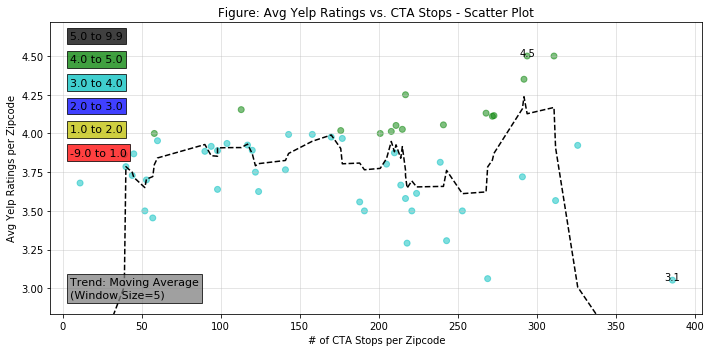

In [12]:
# 
plot_dict = {
    'data_df':merged_rest_df,
    'y_column':'Avg Rating',
    'x_column':'Total CTA Stops',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],
    'ma_window_size':5,
    'chart_title':'Figure: Avg Yelp Ratings vs. CTA Stops - Scatter Plot',
    'y_label':'Avg Yelp Ratings per Zipcode',
    'x_label':'# of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Scatter.png'
}

gen_scatter_plot(plot_dict)


### Quick Analysis of Above: "Figure: Avg Yelp Ratings vs. CTA Stops - Scatter Plot"
* Moving average trend of the Average Yelp Ratings per Zipcode seems relatively flat or a fairly mild decline until about 300 CTA stops per zipcode, which shows an increase.
* Follow-up analysis with  boxplots using bins based upon the # of CTA Stops per Zipcode might provide an visual indication of the variation and its significance

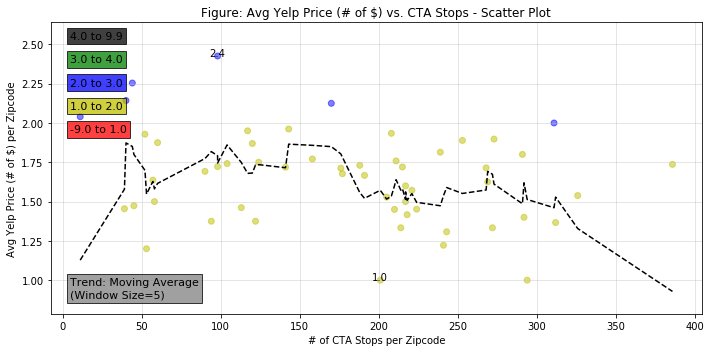

In [13]:
# 
plot_dict = {
    'data_df':merged_rest_df,
    'y_column':'Avg Price (# of $)',
    'x_column':'Total CTA Stops',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],
    'ma_window_size':5,
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. CTA Stops - Scatter Plot',
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'x_label':'# of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Scatter.png'
}

gen_scatter_plot(plot_dict)


### Quick Analysis of Above: "Figure: Avg Yelp Price (# of $) vs. CTA Stops - Scatter Plot"

* Moving average trend of the Average Yelp Price (# of $) per Zipcode seems to show a mild decline starting with about 100 CTA stops per zipcode
* As with previous figure, will follow-up with boxplots
* Also, a linear regression across at least a range of # of CTA Stop values may be relevant.  Will look further after boxplots are done.

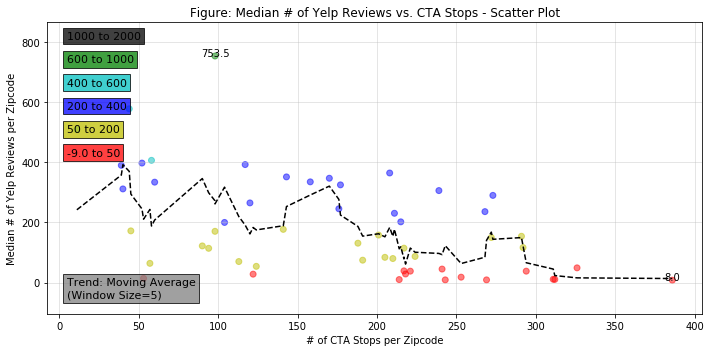

In [14]:
# 
plot_dict = {
    'data_df':merged_rest_df,
    'y_column':'Median Reviews',
    'x_column':'Total CTA Stops',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],
    'ma_window_size':5,
    'chart_title':'Figure: Median # of Yelp Reviews vs. CTA Stops - Scatter Plot',
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'x_label':'# of CTA Stops per Zipcode',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Scatter.png'
}

gen_scatter_plot(plot_dict)


### Quick Analysis of Above: "Figure: Median # of Yelp Reviews vs. CTA Stops - Scatter Plot"
* Most interesting plot so far.
* Moving average trend of the Median # of Yelp Reviews per Zipcode shows a clear decline across the entire range of # of CTA Stops per Zipcode values
* As with previous figures, will follow-up with boxplots, but the distribution of individual sample points seem to show the same pattern of decline - _very exciting!_
* Expecting that a linear regression across will show a usable trend.
* Questions to consider:
    * What does it mean that restaurants in zipcodes with fewer CTA stops tend to have a higher number of Yelp reviews?
    * And, what does it mean it the context of the other relationships plotted above?

In [15]:
merged_rest_df.head()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude
zip,,,,,,,,,
60601,14,3.500000,11535,397.5,823.928571,1.928571,52.0,41.885310,-87.622116
60602,11,3.863636,4086,390.0,371.454545,1.454545,39.0,41.883073,-87.629149
60603,25,3.680000,14205,509.0,568.200000,2.040000,11.0,41.880188,-87.625509
60604,2,4.000000,813,406.5,406.500000,1.500000,58.0,41.878095,-87.628461
60605,32,3.953125,14871,334.0,464.718750,1.875000,60.0,41.867566,-87.617228


In [16]:
merged_rest_df.describe()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,28.236364,3.823583,10061.545455,185.790909,256.811180,1.657117,176.618182,41.869512,-87.673519
std,24.074701,0.300941,14058.017414,165.318511,241.378175,0.290808,89.998866,0.091434,0.062758
min,1.000000,3.052632,11.000000,8.000000,9.842105,1.000000,11.000000,41.663809,-87.827132
25%,10.500000,3.631944,747.000000,47.000000,83.388889,1.453079,101.000000,41.805907,-87.712374
50%,20.000000,3.875000,3694.000000,150.000000,164.541667,1.692308,191.000000,41.882066,-87.662604
75%,37.000000,4.000000,13943.500000,308.750000,406.380435,1.841759,240.000000,41.943241,-87.628805
max,83.000000,4.500000,62914.000000,753.500000,1165.074074,2.425926,386.000000,42.010019,-87.552739


## Comparison of ratings and transit stop density on per-zipcode basis using bar charts with error bars (or box plots)

### Create bins based upon # of CTA Stops per Zipcode for use in bar and boxplot charts

In [17]:
# Define size of each bin for 'Total CTA Stops'
bin_size = 30

# Set the bin min and max based upon the range of values in 'Total CTA Stops'
x_val_min = round(merged_rest_df['Total CTA Stops'].min(),-2)
x_val_max = round(merged_rest_df['Total CTA Stops'].max(),-2)

# Create the bins, and be sure to include a binfor x_val_max
# Note: Bins are [lower, upper)
bin_thresh = list(np.arange(x_val_min, x_val_max+bin_size, bin_size))

In [18]:
# Create bins for based upon the Actual Latitude of the cities
cta_stop_bins = pd.cut(x=merged_rest_df['Total CTA Stops'], bins=bin_thresh, right=False)
cta_stop_bins.head()

zip
60601    [30.0, 60.0)
60602    [30.0, 60.0)
60603     [0.0, 30.0)
60604    [30.0, 60.0)
60605    [60.0, 90.0)
Name: Total CTA Stops, dtype: category
Categories (14, interval[float64]): [[0.0, 30.0) < [30.0, 60.0) < [60.0, 90.0) < [90.0, 120.0) ... [300.0, 330.0) < [330.0, 360.0) < [360.0, 390.0) < [390.0, 420.0)]

In [19]:
merged_rest_df['Total CTA Stops Bin'] = cta_stop_bins
merged_rest_df.head()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude,Total CTA Stops Bin
zip,,,,,,,,,,
60601,14,3.500000,11535,397.5,823.928571,1.928571,52.0,41.885310,-87.622116,"[30.0, 60.0)"
60602,11,3.863636,4086,390.0,371.454545,1.454545,39.0,41.883073,-87.629149,"[30.0, 60.0)"
60603,25,3.680000,14205,509.0,568.200000,2.040000,11.0,41.880188,-87.625509,"[0.0, 30.0)"
60604,2,4.000000,813,406.5,406.500000,1.500000,58.0,41.878095,-87.628461,"[30.0, 60.0)"
60605,32,3.953125,14871,334.0,464.718750,1.875000,60.0,41.867566,-87.617228,"[60.0, 90.0)"


In [20]:
# Create grouping of the data based upon the bins
c_cta_stop_bin_g = merged_rest_df.groupby('Total CTA Stops Bin')

#### Generate DataFrame using Median as the aggregation function
* This means that the per-CTA Stop binned aggregates will be "Median of Averages" or "Median of Medians" of the underlying data in the merged dataframe
* Question: Would there be a significant difference in the results if we used Average (mean) as the aggregation function for the per-CFA Stop binned aggregates?

In [21]:
# Calculate median values
agg_dict= {'Total Restaurants':np.median,
           'Avg Rating':np.median,
           'Total Reviews':np.median,
           'Median Reviews':np.median,
           'Avg Reviews':np.median,
           'Avg Price (# of $)':np.median,
           'Avg Reviews':np.median,
          }

c_cta_stop_bin_df = c_cta_stop_bin_g.agg(agg_dict).reset_index(drop=False)
c_cta_stop_bin_df.head()

,Total CTA Stops Bin,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $)
0,"[0.0, 30.0)",25.0,3.680000,14205.0,509.00,568.200000,2.040000
1,"[30.0, 60.0)",12.5,3.757264,5067.5,350.75,388.977273,1.568182
2,"[60.0, 90.0)",32.0,3.953125,14871.0,334.00,464.718750,1.875000
3,"[90.0, 120.0)",24.0,3.916667,3949.0,170.50,172.444444,1.722222
4,"[120.0, 150.0)",23.0,3.765625,9344.0,177.00,201.578125,1.750000


In [22]:
# Calculate the standard error of the means
agg_dict= {'Total Restaurants':stats.sem,
           'Avg Rating':stats.sem,
           'Total Reviews':stats.sem,
           'Median Reviews':stats.sem,
           'Avg Reviews':stats.sem,
           'Avg Price (# of $)':stats.sem,
           'Avg Reviews':stats.sem,
          }

c_cta_stop_bin_sem_df = c_cta_stop_bin_g.agg(agg_dict).reset_index(drop=False)
c_cta_stop_bin_sem_df.head()

C:\Users\dadja\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\dadja\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Total CTA Stops Bin,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $)
0,"[0.0, 30.0)",NaN,NaN,NaN,NaN,NaN,NaN
1,"[30.0, 60.0)",6.433555,0.065769,5653.485406,68.097615,106.191028,0.131002
2,"[60.0, 90.0)",NaN,NaN,NaN,NaN,NaN,NaN
3,"[90.0, 120.0)",5.070255,0.056667,8336.085957,91.178508,143.482559,0.131190
4,"[120.0, 150.0)",14.636940,0.063242,7134.185441,61.443551,86.490707,0.099879


### Generate bar plots based upon # of CTA Stops per Zipcode

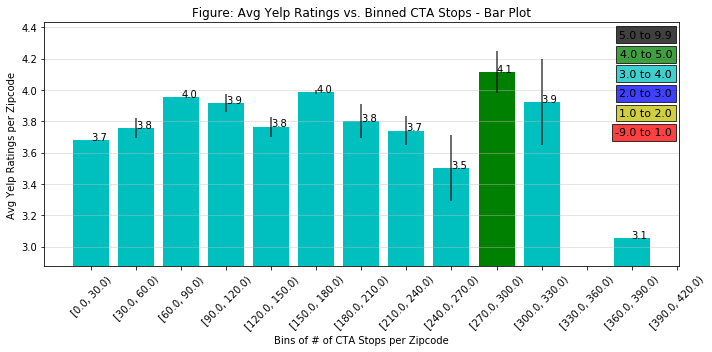

In [24]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Avg Rating',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot',
    'y_label':'Avg Yelp Ratings per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar.png'
}

gen_bar_plot(plot_dict)


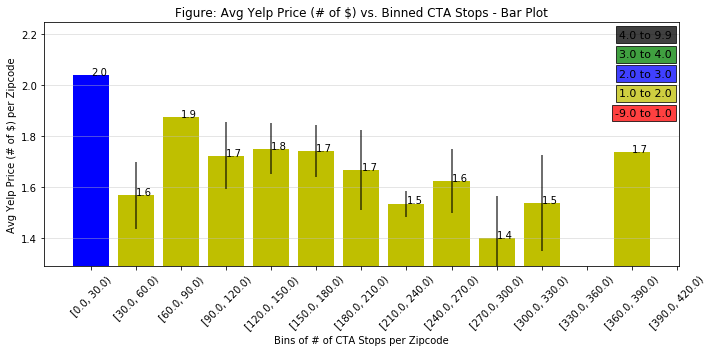

In [25]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Avg Price (# of $)',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. Binned CTA Stops - Bar Plot',
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar.png'
}

gen_bar_plot(plot_dict)


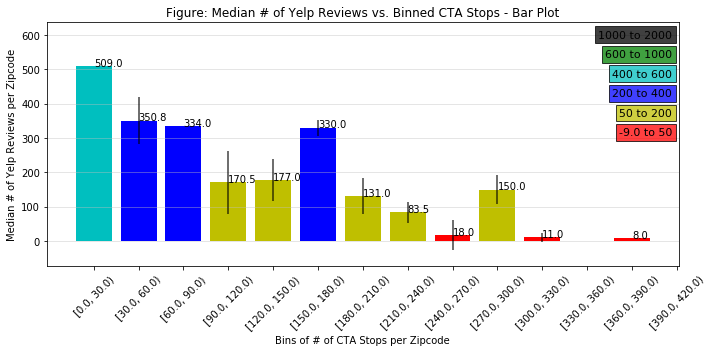

In [26]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Median Reviews',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],
    'ma_window_size':5,
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot',
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar.png'
}

gen_bar_plot(plot_dict)


#### Side Investigation: Use Average vs. Median for per-bin aggregation -- any significant difference?
* This side investigation just checks if using Average (mean) aggregates makes any significant difference in the bar charts vs. what we see with the Median aggregates used above.
* Result: The plots below generated using Average (mean) aggregates don't show any pattern/trend that is significantly different than when Median aggregates were used.  Will stick with the median agg results for further follow-up investigations...

In [27]:
# Calculate average (mean) aggregates
agg_dict= {'Total Restaurants':np.mean,
           'Avg Rating':np.mean,
           'Total Reviews':np.mean,
           'Median Reviews':np.mean,
           'Avg Reviews':np.mean,
           'Avg Price (# of $)':np.mean,
           'Avg Reviews':np.mean,
          }

c_cta_stop_bin_avg_df = c_cta_stop_bin_g.agg(agg_dict).reset_index(drop=False)
c_cta_stop_bin_avg_df

,Total CTA Stops Bin,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $)
0,"[0.0, 30.0)",25.000000,3.680000,14205.000000,509.000000,568.200000,2.040000
1,"[30.0, 60.0)",18.625000,3.737641,11297.250000,291.687500,442.926584,1.698782
2,"[60.0, 90.0)",32.000000,3.953125,14871.000000,334.000000,464.718750,1.875000
3,"[90.0, 120.0)",26.571429,3.906199,13447.571429,260.357143,362.378857,1.766990
4,"[120.0, 150.0)",36.200000,3.805104,12618.000000,175.100000,256.788953,1.734971
5,"[150.0, 180.0)",64.500000,3.989258,27929.250000,313.125000,439.758947,1.821501
6,"[180.0, 210.0)",32.400000,3.774547,9618.400000,162.400000,204.199700,1.571990
7,"[210.0, 240.0)",28.300000,3.766858,6208.600000,113.550000,148.896184,1.561562
8,"[240.0, 270.0)",18.000000,3.611340,2869.200000,63.400000,94.759676,1.551618
9,"[270.0, 300.0)",24.800000,4.159299,7764.600000,149.700000,175.053607,1.486154


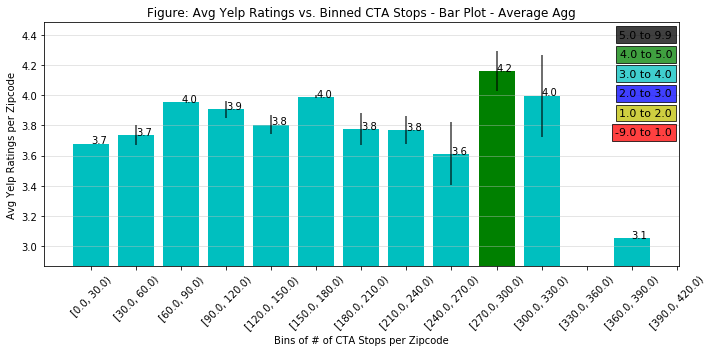

In [28]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_avg_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Avg Rating',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot - Average Agg',
    'y_label':'Avg Yelp Ratings per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar_Average_Agg.png'
}

gen_bar_plot(plot_dict)


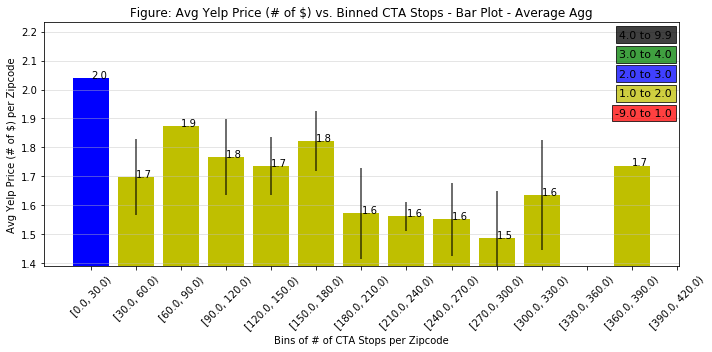

In [29]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_avg_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Avg Price (# of $)',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. Binned CTA Stops - Bar Plot - Average Agg',
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar_Average_Agg.png'
}

gen_bar_plot(plot_dict)


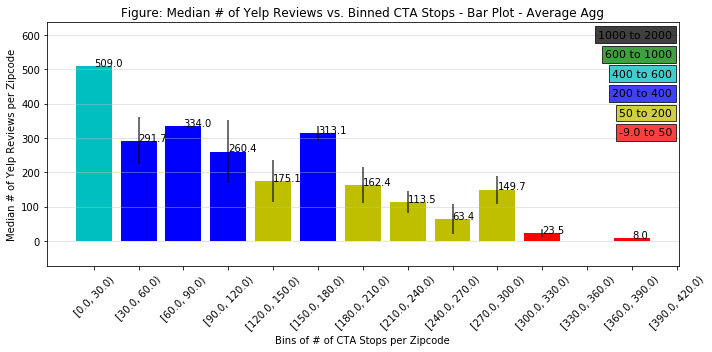

In [30]:
# 
plot_dict = {
    'data_df':c_cta_stop_bin_avg_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_column':'Median Reviews',
    'x_column':'Total CTA Stops Bin',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],
    'ma_window_size':5,
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot - Average Agg',
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'x_label':'Bins of # of CTA Stops per Zipcode',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_Average_Agg.png'
}

gen_bar_plot(plot_dict)


## <span style="color:darkblue">Follow-up On Initial Results</span>
### <span style="color:blue">Average Yelp Ratings per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar.png" /> |

* Moving average trend of the Average Yelp Ratings per Zipcode seems relatively flat or a fairly mild decline until about 300 CTA stops per zipcode, which shows a peak.
* <span style="color:maroon">Questions to consider:
    * What zipcodes are associated with the peak value at around 300 CTA stops per zipcode?
    * What demographic or other factors might shed light on this peak?
</span>

In [31]:
c_cta_stop_bin_df

,Total CTA Stops Bin,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $)
0,"[0.0, 30.0)",25.0,3.680000,14205.0,509.00,568.200000,2.040000
1,"[30.0, 60.0)",12.5,3.757264,5067.5,350.75,388.977273,1.568182
2,"[60.0, 90.0)",32.0,3.953125,14871.0,334.00,464.718750,1.875000
3,"[90.0, 120.0)",24.0,3.916667,3949.0,170.50,172.444444,1.722222
4,"[120.0, 150.0)",23.0,3.765625,9344.0,177.00,201.578125,1.750000
5,"[150.0, 180.0)",72.0,3.985269,30771.0,330.00,440.514769,1.741792
6,"[180.0, 210.0)",26.0,3.801887,4438.0,131.00,158.000000,1.666667
7,"[210.0, 240.0)",22.5,3.740310,1922.0,83.50,99.708065,1.535714
8,"[240.0, 270.0)",13.0,3.500000,681.0,18.00,75.666667,1.625000
9,"[270.0, 300.0)",10.0,4.115385,1243.0,150.00,138.111111,1.400000


In [32]:
merged_rest_df.head()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude,Total CTA Stops Bin
zip,,,,,,,,,,
60601,14,3.500000,11535,397.5,823.928571,1.928571,52.0,41.885310,-87.622116,"[30.0, 60.0)"
60602,11,3.863636,4086,390.0,371.454545,1.454545,39.0,41.883073,-87.629149,"[30.0, 60.0)"
60603,25,3.680000,14205,509.0,568.200000,2.040000,11.0,41.880188,-87.625509,"[0.0, 30.0)"
60604,2,4.000000,813,406.5,406.500000,1.500000,58.0,41.878095,-87.628461,"[30.0, 60.0)"
60605,32,3.953125,14871,334.0,464.718750,1.875000,60.0,41.867566,-87.617228,"[60.0, 90.0)"


In [33]:
merged_rest_df.describe()

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,28.236364,3.823583,10061.545455,185.790909,256.811180,1.657117,176.618182,41.869512,-87.673519
std,24.074701,0.300941,14058.017414,165.318511,241.378175,0.290808,89.998866,0.091434,0.062758
min,1.000000,3.052632,11.000000,8.000000,9.842105,1.000000,11.000000,41.663809,-87.827132
25%,10.500000,3.631944,747.000000,47.000000,83.388889,1.453079,101.000000,41.805907,-87.712374
50%,20.000000,3.875000,3694.000000,150.000000,164.541667,1.692308,191.000000,41.882066,-87.662604
75%,37.000000,4.000000,13943.500000,308.750000,406.380435,1.841759,240.000000,41.943241,-87.628805
max,83.000000,4.500000,62914.000000,753.500000,1165.074074,2.425926,386.000000,42.010019,-87.552739


### The 5 zip codes that represent the peak in Median Avg Yelp Rating for Zipcodes with 270-300 CTA stops

In [34]:
merged_rest_df[ merged_rest_df['Total CTA Stops Bin'] == pd.Interval(270.0, 300.0, closed='left') ]

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude,Total CTA Stops Bin
zip,,,,,,,,,,
60609,2,4.500000,76,38.0,38.000000,1.000000,294.0,41.812680,-87.656935,"[270.0, 300.0)"
60612,9,4.111111,1243,150.0,138.111111,1.333333,272.0,41.880320,-87.687749,"[270.0, 300.0)"
60623,10,4.350000,1104,116.5,110.400000,1.400000,292.0,41.848897,-87.717661,"[270.0, 300.0)"
60641,25,3.720000,4492,154.0,179.680000,1.800000,291.0,41.946606,-87.746787,"[270.0, 300.0)"
60647,78,4.115385,31908,290.0,409.076923,1.897436,273.0,41.921215,-87.701028,"[270.0, 300.0)"


In [35]:
merged_rest_df[ merged_rest_df['Total CTA Stops Bin'] == pd.Interval(300.0, 330.0, closed='left') ]

,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $),Total CTA Stops,Latitude,Longitude,Total CTA Stops Bin
zip,,,,,,,,,,
60617,30,3.566667,515,10.5,17.166667,1.366667,312.0,41.718197,-87.552739,"[300.0, 330.0)"
60621,1,4.500000,11,11.0,11.000000,2.000000,311.0,41.776382,-87.639572,"[300.0, 330.0)"
60632,13,3.923077,931,49.0,71.615385,1.538462,326.0,41.810166,-87.713252,"[300.0, 330.0)"


#### Let's add to the bar chart a line showing the per-bin Median "Total Restaurants" to see if there's a correlation
* Modified the bar plotting function to optionally plot another series of data in the same dataframe on a secondary axis on the same chart
* The bar plot of Avg Yelp Ratings with secondary plots of Total Restaurants, Median Reviews, and Total Reviews don't show any strong correlations
* The bar plot of Avg Yelp Ratings with secondary plot of Avg Price also does not show a strong overall correlation, but, it is interesting to note that the bin that has the highest Median Avg Yelp Rating [270.0, 300.0) also has the lowest Median Avg Price.  Coincidence?  Some other factor to consider?

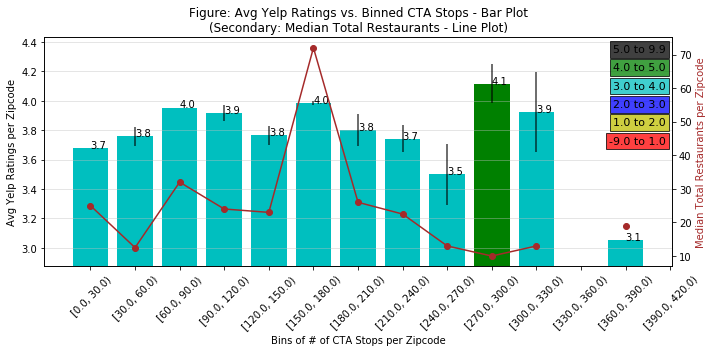

In [36]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Total Restaurants - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar_and_Secondary_Median_Total_Restaurants_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Ratings per Zipcode',
    'y_column':'Avg Rating',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],

    'y2_label':'Median Total Restaurants per Zipcode',
    'y2_column':'Total Restaurants',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

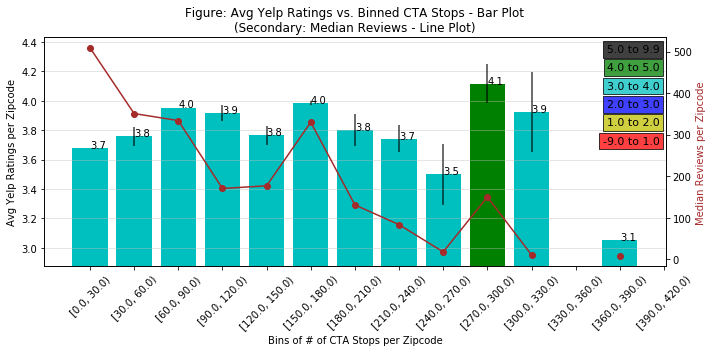

In [37]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Reviews - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar_and_Secondary_Median_Reviews_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Ratings per Zipcode',
    'y_column':'Avg Rating',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],

    'y2_label':'Median Reviews per Zipcode',
    'y2_column':'Median Reviews',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

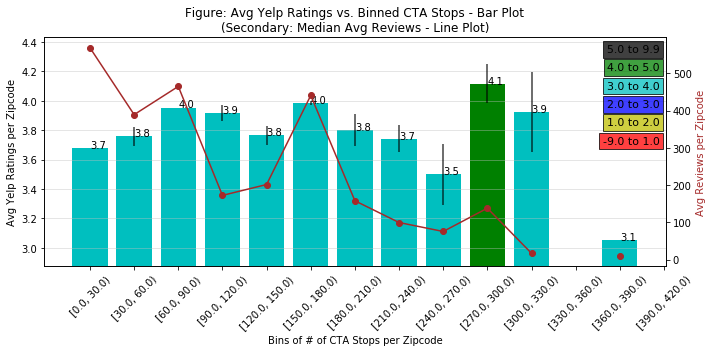

In [38]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Reviews - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar_and_Secondary_Avg_Reviews_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Ratings per Zipcode',
    'y_column':'Avg Rating',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],

    'y2_label':'Avg Reviews per Zipcode',
    'y2_column':'Avg Reviews',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

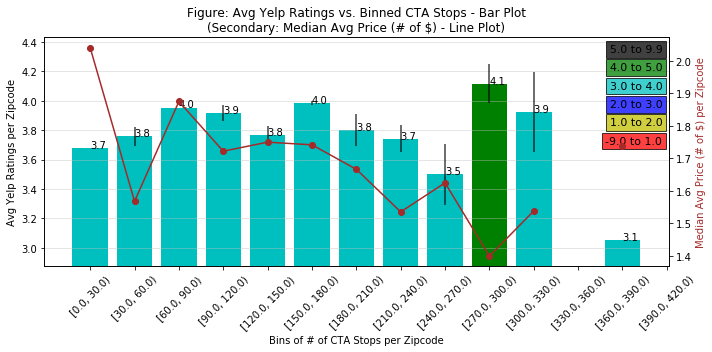

In [39]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Ratings vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Price (# of $) - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Ratings_vs_CTA_Stops_Bar_and_Secondary_Avg_Price_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Ratings per Zipcode',
    'y_column':'Avg Rating',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.9],

    'y2_label':'Median Avg Price (# of $) per Zipcode',
    'y2_column':'Avg Price (# of $)',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

### <span style="color:blue">Average Yelp Price (# of $) per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Avg_Yelp_Price_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar.png" /> |

* Moving average trend of the Average Yelp Price (# of $) per Zipcode seems to show a mild decline starting with about 100 CTA stops per zipcode
* A linear regression across at least a range of # of CTA Stop values may be relevant.
<br>


#### Let's add some secondary plots to see if anything looks interesting
* After trying several plots, plots of Median Avg Yelp Price per Zipcode w/ Median Reviews per Zipcode appear to show some correlation.  Will check for this with a linear regression - below...
* Will also add a linear trend line - below...

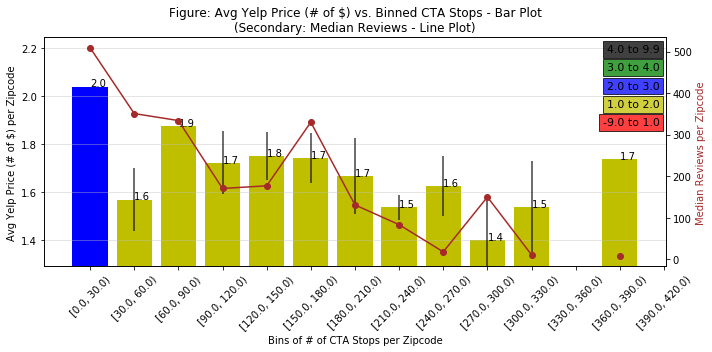

In [40]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Reviews - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar_and_Secondary_Median_Reviews_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'y_column':'Avg Price (# of $)',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],

    'y2_label':'Median Reviews per Zipcode',
    'y2_column':'Median Reviews',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)


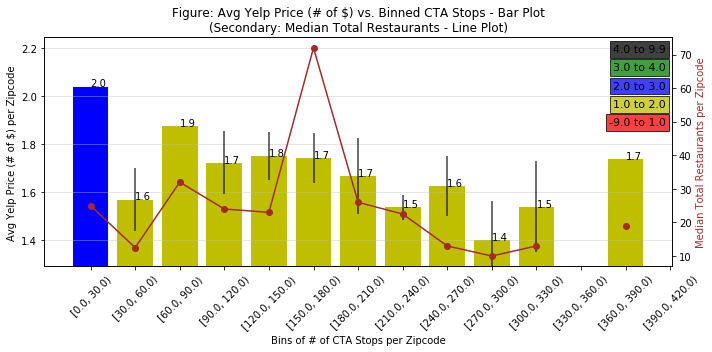

In [41]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Total Restaurants - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar_and_Secondary_Total_Restaurants_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'y_column':'Avg Price (# of $)',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],

    'y2_label':'Median Total Restaurants per Zipcode',
    'y2_column':'Total Restaurants',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)


### <span style="color:blue">Median # of Yelp Reviews per Zipcode vs. # of CTA Stops per Zipcode</span>

|Scatter|Bar|
|-----------|------------------|
|<img src="../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Scatter.png" /> | <img src="../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar.png" /> |

* Most interesting plot so far.
* Moving average trend of the Median # of Yelp Reviews per Zipcode shows a clear decline across the entire range of # of CTA Stops per Zipcode values
* The distribution of individual sample points in the scatter plot and the error bars in the bar plot both seem to support that the decline is significant - _very exciting!_
* Expecting that a linear regression across will show a usable trend.
* <span style="color:maroon">Questions to consider:
    * What does it mean that restaurants in zipcodes with fewer CTA stops tend to have a higher number of Yelp reviews?
    * And, what does it mean it the context of the other relationships plotted above?
</span>
<br>

#### Let's add some secondary plots to see what looks interesting
* As noted before, a clear apparent relationship between Median # of Yelp Reviews per Zipcode and Median Avg Price. (FYI: The complementary bar plot Median Avg Price w/ secondary Median # of Yelp Reviews per Zipcode is probably better visually)
* Correlation of Median # of Yelp Reviews per Zipcode with Median Avg Ratings is not as clear -- will wait for regression analysis (below)

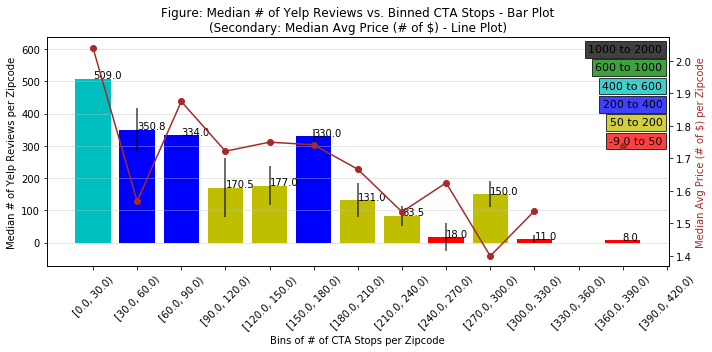

In [42]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Price (# of $) - Line Plot)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_and_Secondary_Avg_Price_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'y2_label':'Median Avg Price (# of $) per Zipcode',
    'y2_column':'Avg Price (# of $)',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

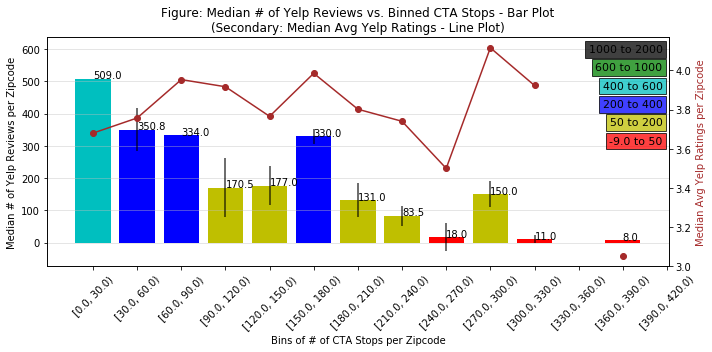

In [43]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Yelp Ratings - Line Plot)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_and_Secondary_Avg_Yelp_Ratings_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'y2_label':'Median Avg Yelp Ratings per Zipcode',
    'y2_column':'Avg Rating',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

## Linear regression analysis to determine trend line characteristics for:
* The plot [Median # of Yelp Reviews per Zipcode vs. # of CTA Stops per Zipcode] seems to have the most obvious apparent correlation so far, so let's focus on this for now...

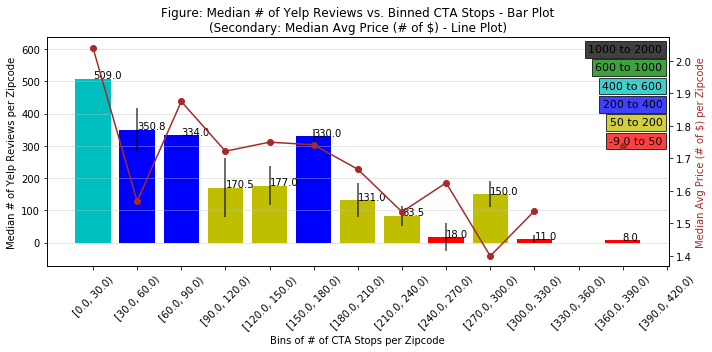

In [44]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Price (# of $) - Line Plot)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_and_Secondary_Avg_Price_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'y2_label':'Median Avg Price (# of $) per Zipcode',
    'y2_column':'Avg Price (# of $)',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

In [45]:
# Let's check to see a reasonable range of bins for the regression analysis
c_cta_stop_bin_df

,Total CTA Stops Bin,Total Restaurants,Avg Rating,Total Reviews,Median Reviews,Avg Reviews,Avg Price (# of $)
0,"[0.0, 30.0)",25.0,3.680000,14205.0,509.00,568.200000,2.040000
1,"[30.0, 60.0)",12.5,3.757264,5067.5,350.75,388.977273,1.568182
2,"[60.0, 90.0)",32.0,3.953125,14871.0,334.00,464.718750,1.875000
3,"[90.0, 120.0)",24.0,3.916667,3949.0,170.50,172.444444,1.722222
4,"[120.0, 150.0)",23.0,3.765625,9344.0,177.00,201.578125,1.750000
5,"[150.0, 180.0)",72.0,3.985269,30771.0,330.00,440.514769,1.741792
6,"[180.0, 210.0)",26.0,3.801887,4438.0,131.00,158.000000,1.666667
7,"[210.0, 240.0)",22.5,3.740310,1922.0,83.50,99.708065,1.535714
8,"[240.0, 270.0)",13.0,3.500000,681.0,18.00,75.666667,1.625000
9,"[270.0, 300.0)",10.0,4.115385,1243.0,150.00,138.111111,1.400000


In [46]:
# Linear Regression -- but only the first 12 elements since NaN appear in later bins
# and excluding the data for bin [360, 390) doesn't seem too risky...
y_axis = c_cta_stop_bin_df['Median Reviews'][0:11]
x_axis = np.arange(0,11)

In [47]:
a_start=None
a_stop=None
c_cta_stop_bin_df['Median Reviews'][a_start:a_stop]

0     509.00
1     350.75
2     334.00
3     170.50
4     177.00
5     330.00
6     131.00
7      83.50
8      18.00
9     150.00
10     11.00
11       NaN
12      8.00
13       NaN
Name: Median Reviews, dtype: float64

In [49]:
tl = gen_linear_trend( range(0,len(c_cta_stop_bin_df['Median Reviews'])),
                       c_cta_stop_bin_df['Median Reviews'], 0, 11)
pprint(tl)

{'trend_label': 'Trend: y = -40.55 x [CTA Stop Bin] + 408.66\n'
                'Correlation (R-Value): -0.86\n'
                'Probablity of Linear Relationship (p-Value): 99.93%',
 'trend_line': array([408.65909091, 368.10454545, 327.55      , 286.99545455,
       246.44090909, 205.88636364, 165.33181818, 124.77727273,
        84.22272727,  43.66818182,   3.11363636])}


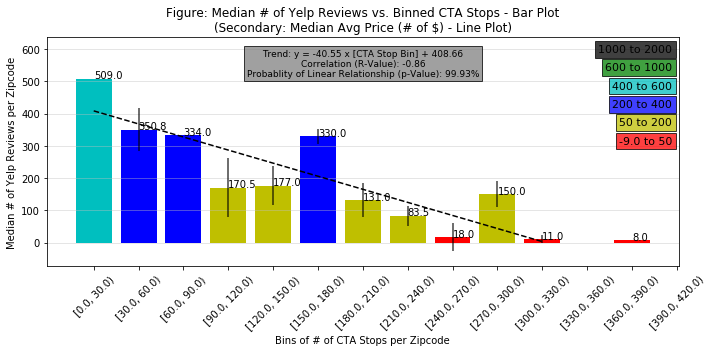

In [50]:
# 
plot_dict = {
    'chart_title':'Figure: Median # of Yelp Reviews vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Avg Price (# of $) - Line Plot)',
    'save_file':'../Chart/Median_Yelp_Reviews_vs_CTA_Stops_Bar_and_Secondary_Avg_Price_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Median # of Yelp Reviews per Zipcode',
    'y_column':'Median Reviews',
    'color_list':'krybcgk',
    'color_thresh':[-9.0, 50, 200, 400, 600, 1000, 2000],

    'data_trend': tl['trend_line'],
    'data_trend_label': tl['trend_label'],
    'data_trend_label_loc_h': 0.5,
    'data_trend_label_loc_v': 0.95,
    
#    'y2_label':'Median Avg Price (# of $) per Zipcode',
#    'y2_column':'Avg Price (# of $)',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)

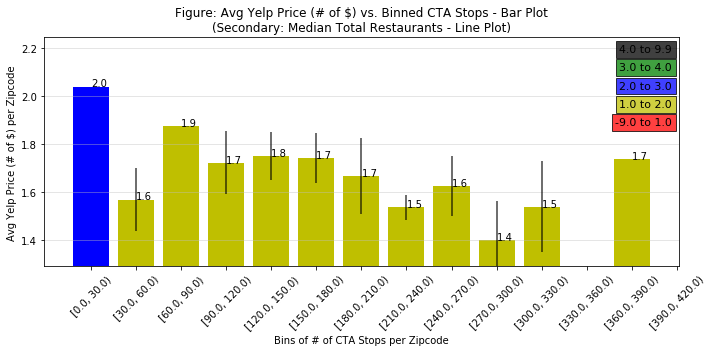

In [51]:
# 
plot_dict = {
    'chart_title':'Figure: Avg Yelp Price (# of $) vs. Binned CTA Stops - Bar Plot\n(Secondary: Median Total Restaurants - Line Plot)',
    'save_file':'../Chart/Avg_Yelp_Price_vs_CTA_Stops_Bar_and_Secondary_Total_Restaurants_Line.png',

    'data_df':c_cta_stop_bin_df,
    'data_sem_df':c_cta_stop_bin_sem_df,
    'y_label':'Avg Yelp Price (# of $) per Zipcode',
    'y_column':'Avg Price (# of $)',
    'color_list':'krybgk',
    'color_thresh':[-9.0, 1.0, 2.0, 3.0, 4.0,9.9],

#    'y2_label':'Median Total Restaurants per Zipcode',
#    'y2_column':'Total Restaurants',

    'x_label':'Bins of # of CTA Stops per Zipcode',
    'x_column':'Total CTA Stops Bin'
}

gen_bar_plot(plot_dict)


## Create a Google Maps plot of the 3 Yelp metrics noted above:
* Marker layer of all of the Zipcode lat/long coordinates, with the marker size determined by a Yelp metric.
* Marker labels providing the key Yelp metric.
* Marker info boxes providing additional Yelp metric and the associated # of Chicago CTA Stops for each zipcode.
* A heat map layer of the # of Chicago CTA Stops